<a href="https://colab.research.google.com/github/NataliaKowal/Ukryte-modele-Markowa/blob/main/Gramatyki%2C_automaty_i_biokomputery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalacja pakietów

In [ ]:
!pip install Biopython biotite pyhmmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5


# Importy

In [ ]:
from Bio import Entrez, SeqIO
import pyhmmer
from pyhmmer.easel import Alphabet, TextSequence, TextMSA, SequenceFile, DigitalSequenceBlock, DigitalSequence
from pyhmmer.plan7 import Pipeline, LongTargetsPipeline, HMM, Profile, OptimizedProfile, Builder, Background
from ftplib import FTP
from __future__ import annotations
import tarfile
from pyhmmer import easel,plan7
from pyhmmer.plan7 import Pipeline
from typing import List, Tuple
import pickle
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# Pobieranie sekwencji poszukiwanego genu (Mikołaj Kikolski)

Wyszukiwanym genem jest TPH1 kodujący enzym - hydroksylazę tryptofanową, która bierze udział w przekształcaniu tryptofanu w serotoninę. Gen TPH1 wybrano ponieważ występuje głównie w mikrobiomie, a TPH2, który pełni tą samą funkcję występuje jedynie w neuronach.

Identyfikator genu w Entrez:
- **DB Protein:** [NP_004170](https://www.ncbi.nlm.nih.gov/protein/NP_004170.1)
- **DB Nucleotide:** [NM_004179](https://www.ncbi.nlm.nih.gov/nuccore/NM_004179.3)


In [ ]:
def fetch_entrez_sequence(entrez_id: str, email: str, db: str = "protein") -> str:
    """
    Fetches a sequence from the NCBI Entrez database.

    Args:
        entrez_id (str): The accession ID of the sequence to fetch.
            Should start with 'NP' for protein sequences or 'NM' for nucleotide sequences.
        email (str): A valid email address, required by NCBI Entrez for user identification.
        db (str): The NCBI database to fetch the sequence from, either "protein" or "nucleotide".
            Default is "protein".

    Returns:
        str: The sequence as a string.

    Raises:
        ValueError: If the email is invalid (does not contain '@').
        ValueError: If the db parameter is not "nucleotide" or "protein".
        ValueError: If the entrez_id does not match the specified database
            (e.g., "NM" prefix for nucleotide and "NP" prefix for protein).

    Example:
    >>> fetch_entrez_sequence("NP_775082", "your_email@example.com", db="protein")
    'MKTAYIAKQRQISFVKSHFSRQDIL...'
    """
    if email.find("@") == -1:
        raise ValueError("Provide a valid e-mail address")
    if db not in ["nucleotide", "protein"]:
        raise ValueError("Available databases: 'nucleotide', 'protein'")
    if (db == "protein" and entrez_id.find("NM") != -1) or (db == "nucleotide" and entrez_id.find("NP") != -1):
        raise ValueError("Wrong accession type. Protein database uses NP accessions and Nucleotide uses NM.")

    Entrez.email = email

    with Entrez.efetch(db=db, id=entrez_id, rettype="gb", retmode="text") as handle:
        record = SeqIO.read(handle, "genbank")

    return record.seq

protein_sequence = fetch_entrez_sequence("NM_004179", "261830@student.pwr.edu.pl", db="nucleotide")
print(f"TPH1 protein sequence:\n{protein_sequence}")

TPH1 protein sequence:
GACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAATAAGGAGAACAAAGACCATTCCTTAGAAAGGGGAAGAGCAAGTCTCATTTTTTCCTTAAAGAATGAAGTTGGAGGACTTATAAAAGCCCTGAAAATCTTTCAGGAGAAGCATGTGAATCTGTTACATATCGAGTCCCGAAAATCAAAAAGAAGAAACTCAGAATTTGAGATTTTTGTTGACTGTGACATCAACAGAGAACAATTGAATGATATTTTTCATCTGCTGAAGTCTCATACCAATGTTCTCTCTGTGAATCTACCAGATAATTTTACTTTGAAGGAAGATGGTATGGAAACTGTTCCTTGGTTTCCAAAGAAGATTTCTGACCTGGACCATTGTGCCAACAGAGTTCTGATGTATGGATCTGAACTAGATGCAGACCATCCTGGCTTCAAAGACAATGTCTACCGTAAACGTCGAAAGTATTTTGCGGACTTGGCTATGAACTATAAACATGGAGACCCCATTCCAAAGGTTGAATTCACTGAAGAGGAGATTAAGACCTGGGGAACCGTATTCCAAGAGCTCAACAAACTCTACCCAACCCATGCTTGCAGAGAGTATCTCAAAAACTTACCTTTGCTTTCTAAATATTGTGGATATCGGGAGGATAATATCCCACAATTGGAAGATGTCTCCAACTTTTTAAAAGAGCGTACAGGTTTTTCCATCCGTCCTGTGGCTGGTTACTTATCACCAAGAGATTTCTTATCAGGTTTAGCCTTTCGAGTTTTTCACTGCACTCAATATGTGAGACACAGTTCAGATCCCTTCTATACCCCAGAGCCAGATACCTGCCATGAACTCTTAGGTCATGTCCCGCTTTTGGCTGAACCTAGTTTTGCCCAATTCTCCCAAGAAATTGGCTTGGCTTCTCTTGGCGCTTCAGAGGAGGCTGTTCAAAAAC

# Klasa przechowująca utworzony model (Mikołaj Kikolski)

In [ ]:
class Model:
    """
    A class used to represent a Model containing HMM, Profile, and OptimizedProfile.

    Attributes:
        hmm (HMM): The Hidden Markov Model (HMM) associated with the model.
        profile (Profile): The profile associated with the model.
        optimized_profile (OptimizedProfile): The optimized profile associated with the model.
    """
    hmm: HMM = None
    profile: Profile = None
    optimized_profile: OptimizedProfile = None

    def __repr__(self) -> str:
        """
        Returns a string representation of the Model instance.

        Returns:
            str: A string representation of the Model instance.
        """
        return f"Model: {self.hmm}, {self.profile}, {self.optimized_profile}"

    def get_alphabet(self) -> Alphabet:
        """
        Returns the alphabet used by the HMM.

        Returns:
            Alphabet: The alphabet used by the HMM.
        """
        return self.hmm.alphabet

    def from_tuple(hmm_tuple: tuple[HMM, Profile, OptimizedProfile]) -> Model:
        """
        Creates a Model instance from a tuple containing HMM, Profile, and OptimizedProfile.

        Args:
            hmm_tuple (tuple[HMM, Profile, OptimizedProfile]): A tuple containing HMM, Profile, and OptimizedProfile.

        Returns:
            Model: A Model instance created from the provided tuple.
        """
        hmmw = Model()
        hmmw.hmm, hmmw.profile, hmmw.optimized_profile = hmm_tuple
        return hmmw

Model.from_tuple = staticmethod(Model.from_tuple)

# Budowa modelu wyszukującego zadaną sekwencję (Julia Cieszko)

Na podstawie sekwencji uzyskanej z Entrez tworzymy profil HMM.

In [ ]:
def build_hmm(sequence: str, alphabet: Alphabet = Alphabet.amino()) -> Model:
    """
    Builds a Hidden Markov Model (HMM) profile from a given sequence using the pyhmmer library.

    Args:
        sequence (str): A sequence as a string, used to construct the HMM profile.
        alphabet (Alphabet): pyhmmer Alphabet object used to digitize the sequence. Alphabet.amino() by default. Other valid options: .rna(), .dna()

    Returns:
        Model:
        An object containing:
        - The resulting HMM (pyhmmer.plan7.HMM).
        - The HMM profile (pyhmmer.plan7.Profile).
        - The optimized HMM profile for more efficient searching (pyhmmer.plan7.OptimizedProfile).

    Example:
    >>> model = build_hmm("MKTAYIAKQRQISFVKSHFSRQDIL")
    """
    text_sequence = TextSequence(name=b"TPH1", sequence=str(sequence))

    msa = TextMSA(name=b"Extracted sequence model", sequences=[text_sequence])

    builder = Builder(alphabet)
    bg = Background(alphabet)
    hmm = builder.build_msa(msa.digitize(alphabet), background=bg)
    return Model.from_tuple(hmm)

hmm_model = build_hmm(protein_sequence, alphabet=Alphabet.dna())
print(hmm_model)
print("HMM Model built successfully")

Model: <HMM alphabet=Alphabet.dna() M=4826 name=b'Extracted sequence model'>, <Profile alphabet=Alphabet.dna() M=4826 name=b'Extracted sequence model'>, <OptimizedProfile alphabet=Alphabet.dna() M=4826 name=b'Extracted sequence model'>
HMM Model built successfully


# Montowanie dysku Google Drive

In [ ]:
from google.colab import drive
import os

if not os.path.exists('/content/drive') or not os.listdir('/content/drive'):
    print("Montowanie Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive jest już zamontowany")

Montowanie Google Drive...
Mounted at /content/drive


## Dzielenie długich sekwencji (Natalia Kowal)

In [ ]:
def split_long_sequences(sb: DigitalSequenceBlock, max_length: int = 100_000) -> DigitalSequenceBlock:
    """
    Splits sequences contained in provided DigitalSequenceBlock into roughly equal sized, shorter sequences that can be processed by HMMER

    Args:
        sequence_block (DigitalSequenceBlock): Block of sequences to process
        max_length (int): Maximum allowed sequence length (default: 100000)

    Returns:
        DigitalSequenceBlock: Modified sequence block with split sequences
    """
    csb = sb
    for s in sb:
        print(len(s.sequence))
        if len(s.sequence) > max_length:
            split_pos = len(s.sequence) // 2
            s1, s2 = s.sequence[:split_pos], s.sequence[split_pos:]

            ds1 = DigitalSequence(
                name=s.name,
                sequence=s1,
                alphabet=s.alphabet
            )

            ds2 = DigitalSequence(
                name=s.name,
                sequence=s2,
                alphabet=s.alphabet
            )

            nsb = DigitalSequenceBlock(s.alphabet, [ds1, ds2])

            csb.remove(s)
            for ns in nsb:
                csb.append(ns)
    return csb

# Wyszukiwanie iteracyjne w sekwencjach z mikrobiomu jelitowego za pomocą profilu HMM (Julia Cieszko)

In [ ]:
def search_hmm(model: Model, database_path: str):
    """
    Searches for HMM hits in a given sequence database.

    Args:
        model (HMM): The HMM model to use for the search. # Updated docstring for clarity
        database_path (str): The path to the sequence database file.

    Returns:
        list: A list of hits found in the sequence database.
    """
    p = Pipeline(model.hmm.alphabet)
    total_hits = []

    with SequenceFile(database_path, digital=True) as sf:
        sequences = sf.read_block()
        sequences = split_long_sequences(sequences)

    pipeline_iterator = p.iterate_hmm(model.hmm, sequences)
    iterlimit = 10
    while not pipeline_iterator.converged and iterlimit >= 0:
        try:
            _, hits, _, _, _ = next(pipeline_iterator)
            total_hits.append(hits)
        except:
            return total_hits
        iterlimit -= 1
    return total_hits

In [ ]:
import glob, os

thh = []

for filename in glob.iglob('/content/drive/My Drive/hgg/**', recursive=True):
    if os.path.isfile(filename):

        th = search_hmm(hmm_model, filename)
        thh.append(th)

### Zapis do pliku binarnego (Mikołaj Kikolski)

In [ ]:
# with open("/content/drive/My Drive/hmm_results.pkl", "wb") as f: # NIE RUSZAĆ DOPÓKI NIE ZAPISUJECIE NOWYCH WYNIKÓW
#     pickle.dump(list([th for th in thh if th != [] and th != None]), f)

## Odczyt wyników wyszukiwania z pliku binarnego (Mikołaj Kikolski)

In [ ]:
with open("/content/drive/My Drive/hmm_results.pkl", "rb") as f:
    all_hits = pickle.load(f)

print(all_hits)

[[<pyhmmer.plan7.TopHits object at 0x2fae6e0>, <pyhmmer.plan7.TopHits object at 0x389de10>], [<pyhmmer.plan7.TopHits object at 0x2f44880>, <pyhmmer.plan7.TopHits object at 0x358bc70>, <pyhmmer.plan7.TopHits object at 0x3b6be40>], [<pyhmmer.plan7.TopHits object at 0x3bafe70>, <pyhmmer.plan7.TopHits object at 0x3787f80>], [<pyhmmer.plan7.TopHits object at 0x3703760>, <pyhmmer.plan7.TopHits object at 0x3df9560>], [<pyhmmer.plan7.TopHits object at 0x3df9b10>, <pyhmmer.plan7.TopHits object at 0x3cd8ac0>], [<pyhmmer.plan7.TopHits object at 0x2feceb0>, <pyhmmer.plan7.TopHits object at 0x3f57330>, <pyhmmer.plan7.TopHits object at 0x40c3fb0>], [<pyhmmer.plan7.TopHits object at 0x2fed340>, <pyhmmer.plan7.TopHits object at 0x4108000>], [<pyhmmer.plan7.TopHits object at 0x370cbc0>, <pyhmmer.plan7.TopHits object at 0x42309d0>, <pyhmmer.plan7.TopHits object at 0x44ca660>, <pyhmmer.plan7.TopHits object at 0x49ac210>, <pyhmmer.plan7.TopHits object at 0x4a54ae0>, <pyhmmer.plan7.TopHits object at 0x4cca

In [ ]:
hit_list = []

for thl in all_hits:
    for th in thl:
        for h in th:
            hit_list.append(h)

print(hit_list)

[<pyhmmer.plan7.Hit object at 0x78b88b2f3520>, <pyhmmer.plan7.Hit object at 0x78b88b2f35e0>, <pyhmmer.plan7.Hit object at 0x78b88b2f2d40>, <pyhmmer.plan7.Hit object at 0x78b88b2f1e40>, <pyhmmer.plan7.Hit object at 0x78b88b2f2d10>, <pyhmmer.plan7.Hit object at 0x78b88b2f2800>, <pyhmmer.plan7.Hit object at 0x78b88b2f1ed0>, <pyhmmer.plan7.Hit object at 0x78b88b2f3640>, <pyhmmer.plan7.Hit object at 0x78b88b2f29b0>, <pyhmmer.plan7.Hit object at 0x78b88b2f2710>, <pyhmmer.plan7.Hit object at 0x78b88b2f2ef0>, <pyhmmer.plan7.Hit object at 0x78b88b2f27d0>, <pyhmmer.plan7.Hit object at 0x78b88b2f34f0>, <pyhmmer.plan7.Hit object at 0x78b88b2f2e00>, <pyhmmer.plan7.Hit object at 0x78b88b2f25f0>, <pyhmmer.plan7.Hit object at 0x78b88b2f3730>, <pyhmmer.plan7.Hit object at 0x78b88b2f3340>, <pyhmmer.plan7.Hit object at 0x78b88b2f2cb0>, <pyhmmer.plan7.Hit object at 0x78b88b2f3fa0>, <pyhmmer.plan7.Hit object at 0x78b88b2f3d00>, <pyhmmer.plan7.Hit object at 0x78b88b2f23e0>, <pyhmmer.plan7.Hit object at 0x78

## Podsumowanie wyników dopasowania w tabeli (Julia Cieszko)

In [ ]:
acc, hlen, ev, pv, sc, bd, sm, dm = [], [], [], [], [], [], [], []
for h in hit_list:
    acc.append(str(h.name).replace("b'", "").replace("'", ""))
    hlen.append(h.length)
    ev.append(h.evalue)
    pv.append(h.pvalue)
    sc.append(h.score)
    bd.append(h.best_domain)
    sm.append(h.sum_score)
    dm.append(h.domains)
    # print(h.best_domain.alignment)

summary = pd.DataFrame(data={
    "accession": acc,
    "hit length": hlen,
    "e-value": ev,
    "p-value": pv,
    "score": sc,
    "best domain": bd,
    "sum score": sm,
    "domains": dm
})

summary.sort_values("sum score", ascending=False)

,accession,hit length,e-value,p-value,score,best domain,sum score,domains
699,NODE_366_length_20910_cov_24.1953,20910,0.000000e+00,0.000000e+00,3824.470703,<pyhmmer.plan7.Domain object at 0x78b887021840>,3824.470703,(<pyhmmer.plan7.Domain object at 0x78b88704a18...
648,NODE_366_length_20910_cov_24.1953,20910,0.000000e+00,0.000000e+00,3744.736816,<pyhmmer.plan7.Domain object at 0x78b887020b80>,3744.736816,(<pyhmmer.plan7.Domain object at 0x78b88704a0c...
599,NODE_366_length_20910_cov_24.1953,20910,0.000000e+00,0.000000e+00,3626.264648,<pyhmmer.plan7.Domain object at 0x78b88700fec0>,3626.264648,(<pyhmmer.plan7.Domain object at 0x78b88704a20...
829,NODE_3746_length_8139_cov_11.727859,8139,0.000000e+00,0.000000e+00,3580.358398,<pyhmmer.plan7.Domain object at 0x78b8870238c0>,3568.071289,(<pyhmmer.plan7.Domain object at 0x78b88704a28...
304,NODE_1061_length_20902_cov_8.843910,20902,0.000000e+00,0.000000e+00,3473.238281,<pyhmmer.plan7.Domain object at 0x78b887006480>,3472.343994,(<pyhmmer.plan7.Domain object at 0x78b88704a300>)
553,NODE_366_length_20910_cov_24.1953,20910,0.000000e+00,0.000000e+00,3444.159668,<pyhmmer.plan7.Domain object at 0x78b88700f340>,3442.430176,(<pyhmmer.plan7.Domain object at 0x78b88704a380>)
257,NODE_1061_length_20902_cov_8.843910,20902,0.000000e+00,0.000000e+00,3360.658447,<pyhmmer.plan7.Domain object at 0x78b8872994c0>,3359.777832,(<pyhmmer.plan7.Domain object at 0x78b887049cc0>)
212,NODE_1061_length_20902_cov_8.843910,20902,0.000000e+00,0.000000e+00,3180.910889,<pyhmmer.plan7.Domain object at 0x78b887212d40>,3179.994629,(<pyhmmer.plan7.Domain object at 0x78b887049b80>)
507,NODE_366_length_20910_cov_24.1953,20910,0.000000e+00,0.000000e+00,3086.525146,<pyhmmer.plan7.Domain object at 0x78b88700e780>,3085.027832,(<pyhmmer.plan7.Domain object at 0x78b887049440>)
15,NODE_2637_length_8453_cov_4.302572,8453,0.000000e+00,0.000000e+00,3061.540039,<pyhmmer.plan7.Domain object at 0x78b8872685c0>,3049.093750,(<pyhmmer.plan7.Domain object at 0x78b88704a34...


### Analiza trafień w plikach (Mikołaj Kikolski)

In [ ]:
top_hit_labels = list(set(list(summary.loc[summary["score"] > 1e3]["accession"])))
print(top_hit_labels)

['NODE_2637_length_8453_cov_4.302572', 'NODE_1061_length_20902_cov_8.843910', 'NODE_1061_length_20902_cov_8.843910', 'NODE_1061_length_20902_cov_8.843910', 'NODE_1061_length_20902_cov_8.843910', 'NODE_3267_length_8321_cov_14.646504', 'NODE_1061_length_20902_cov_8.843910', 'NODE_3267_length_8321_cov_14.646504', 'NODE_1061_length_20902_cov_8.843910', 'NODE_3267_length_8321_cov_14.646504', 'NODE_1061_length_20902_cov_8.843910', 'NODE_3267_length_8321_cov_14.646504', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_366_length_20910_cov_24.1953', 'NODE_3746_length_8139_cov_11.727859', 'NODE_3746_length_8139_cov_11.727859']


In [ ]:
import glob, os

th_data = []

for filename in glob.iglob('/content/drive/My Drive/hgg/**', recursive=True):
    if os.path.isfile(filename):
        with open(filename) as f:
            if any(map(f.read().__contains__, top_hit_labels)):
                th_data.append([filename, [thl for thl in top_hit_labels if f.read().find(thl) != -1]])

print(th_data)

[['/content/drive/My Drive/hgg/hgg_mags_2/SRR1237933_bin.33.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_3/SRR2155328_bin.33.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_3/SRR2155347_bin.24.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_4/SRR3993042_bin.38.fa', []]]


In [ ]:
th_data = [['/content/drive/My Drive/hgg/hgg_mags_2/SRR1237933_bin.33.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_3/SRR2155328_bin.33.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_3/SRR2155347_bin.24.fa', []], ['/content/drive/My Drive/hgg/hgg_mags_4/SRR3993042_bin.38.fa', []]]

In [ ]:
th_data = [thd[0].split("/")[-1].split("_")[0].replace("SRR", "") for thd in th_data]
print(th_data)

['1237933', '2155328', '2155347', '3993042']


In [ ]:
import requests

r = requests.get("https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB10915&result=read_run&fields=study_accession,sample_accession,experiment_accession,run_accession,tax_id,scientific_name,fastq_ftp,submitted_ftp,sra_ftp,bam_ftp&format=tsv&download=true&limit=0")
with open("meta.tsv", "wb") as f:
    f.write(r.content)

meta = pd.read_csv("meta.tsv", sep="\t")
meta = meta[["run_accession", "scientific_name"]]
meta["acc_num"] = meta["run_accession"].apply(lambda x: x.replace("ERR", ""))
meta.head(1000)

,run_accession,scientific_name,acc_num
0,ERR1022272,uncultured Clostridium sp.,1022272
1,ERR1022276,uncultured Ruminococcus sp.,1022276
2,ERR1022279,uncultured Faecalibacterium sp.,1022279
3,ERR1022283,Bifidobacterium adolescentis,1022283
4,ERR1022284,Catenibacterium mitsuokai,1022284
...,...,...,...
234,ERR689784,unidentified,689784
235,ERR689785,unidentified,689785
236,ERR689786,unidentified,689786
237,ERR689790,unidentified,689790


In [ ]:
meta[meta["acc_num"].isin(th_data)]

,run_accession,scientific_name,acc_num


In [ ]:
class SingleAlignment:
    def __init__(self, query_bounds, target_bounds, alignment):
        self.query_bounds = query_bounds
        self.target_bounds = target_bounds
        self.alignment = alignment

    def __repr__(self):
        return f"Q: {self.query_bounds}, T: {self.target_bounds}\n{self.alignment}"

    def get_lowest_dist(self):
        return min(self.query_bounds[1] - self.query_bounds[0], self.target_bounds[1] - self.target_bounds[0])

class ParsedAlignment:
    def __init__(self, target_name, domains):
        self.target_name = target_name
        self.domains = domains
        self.alignments = self.extract_alignments()
        self.parsed_alignments = []

    def extract_alignments(self):
        alignments = []
        for d in self.domains:
            alignments.append(d.alignment)

        return alignments

    def get_plot_bound(self):
        return max(list([pa.query_bounds[1] for pa in self.parsed_alignments]) + list([pa.target_bounds[1] for pa in self.parsed_alignments]))

    def export(self, path):
        with open(path, "w") as f:
            f.writelines(self.alignments)

    def draw(self):
        bound = self.get_plot_bound()
        dp = np.zeros([bound, bound])
        for pa in self.parsed_alignments:
            it = pa.get_lowest_dist()
            for i in range(it):
                if pa.alignment[i] != " ":
                    dp[pa.query_bounds[0] + i, pa.target_bounds[0] + i] = 255

        plt.imshow(dp, vmax=255, vmin=0, cmap="gray")
        plt.gca().invert_yaxis()
        plt.ylabel(self.target_name)
        plt.xlabel("TPH1")
        plt.savefig('destination_path.svg', format='svg', dpi=1200)
        plt.show()

    def parse_alignments(self):

        def filter_row(row):
            indices = []
            for el in row.split(" "):
                try:
                    indices.append(int(el))
                except ValueError:
                    pass
            return indices

        def trim_alignment(alignment_rows):
            sequence_start_marker = re.compile("A|T|G|C")
            trim_id = sequence_start_marker.search(alignment_rows[2]).start()
            return alignment_rows[1][trim_id:]

        for alignment in self.alignments:
            alignment_rows = str(alignment).split("\n")
            query_idx = filter_row(alignment_rows[0])
            target_idx = filter_row(alignment_rows[2])
            alignment_result = trim_alignment(alignment_rows)
            self.parsed_alignments.append(SingleAlignment(query_idx, target_idx, alignment_result))



## Generowanie wykresów obrazujących dopasowania

/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


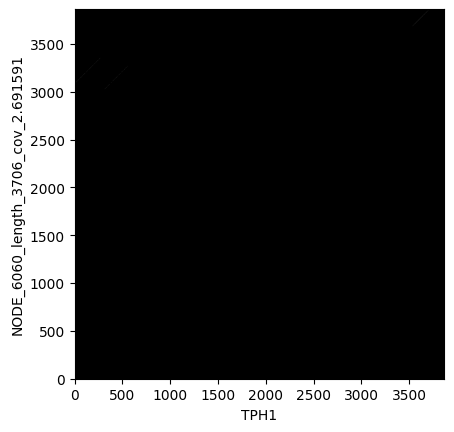

In [ ]:
pa = ParsedAlignment(summary.head(1)["accession"][0], summary.head(1)["domains"][0])
pa.parse_alignments()
pa.draw()

### Dalsze wykresy (Natalia Kowal)

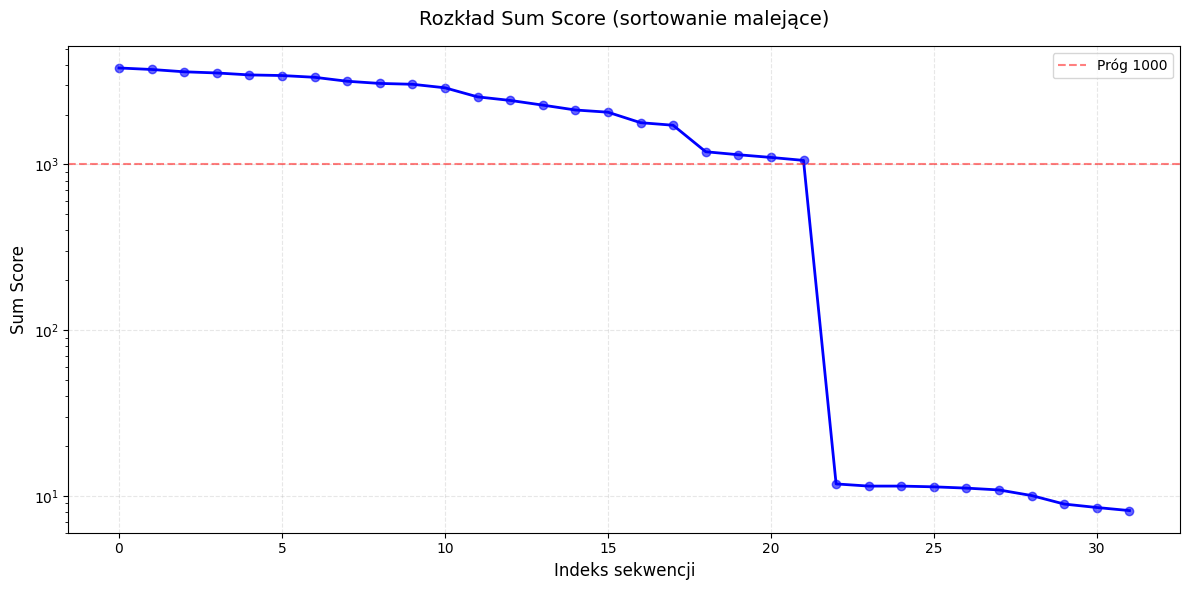


Statystyki:
Liczba sekwencji z sum score > 1000: 22
Liczba sekwencji z sum score < 20: 10


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wczytujemy dane
sum_scores = [3049.09375, 1725.4114990234375, 2068.4912109375, 2436.230712890625,
              2903.30810546875, 1058.6982421875, 3179.99462890625, 1103.1944580078125,
              3359.77783203125, 1145.250244140625, 3472.343994140625, 1193.8448486328125,
              1788.0166015625, 2132.706787109375, 2559.71533203125, 3085.02783203125,
              3442.43017578125, 3626.2646484375, 3744.73681640625, 3824.470703125,
              2282.439453125, 3568.0712890625] + [x for x in [11.141064643859863, 11.460029602050781,
              10.045953750610352, 11.811152458190918, 11.460722923278809, 8.153353691101074,
              8.92629337310791, 11.34330940246582, 10.862120628356934, 8.510749816894531]]

# Sortujemy wartości malejąco
sorted_scores = sorted(sum_scores, reverse=True)

# Tworzymy wykres
plt.figure(figsize=(12, 6))

# Główny wykres
plt.plot(range(len(sorted_scores)), sorted_scores, 'b-', linewidth=2)
plt.scatter(range(len(sorted_scores)), sorted_scores, c='blue', alpha=0.6)

# Dodajemy próg odcięcia
plt.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='Próg 1000')

# Dodajemy etykiety i tytuł
plt.title('Rozkład Sum Score (sortowanie malejące)', fontsize=14, pad=15)
plt.xlabel('Indeks sekwencji', fontsize=12)
plt.ylabel('Sum Score', fontsize=12)

# Dodajemy siatkę
plt.grid(True, linestyle='--', alpha=0.3)

# Używamy skali logarytmicznej dla osi Y
plt.yscale('log')

# Dodajemy legendę
plt.legend()

plt.tight_layout()
plt.show()

# Wyświetlamy podstawowe statystyki
print("\nStatystyki:")
print(f"Liczba sekwencji z sum score > 1000: {len([x for x in sum_scores if x > 1000])}")
print(f"Liczba sekwencji z sum score < 20: {len([x for x in sum_scores if x < 20])}")

Liczba próbek: 113.00
Minimum: 8.04
Maksimum: 3824.47
Średnia: 510.26
Mediana: 10.40
Odchylenie standardowe: 1094.81


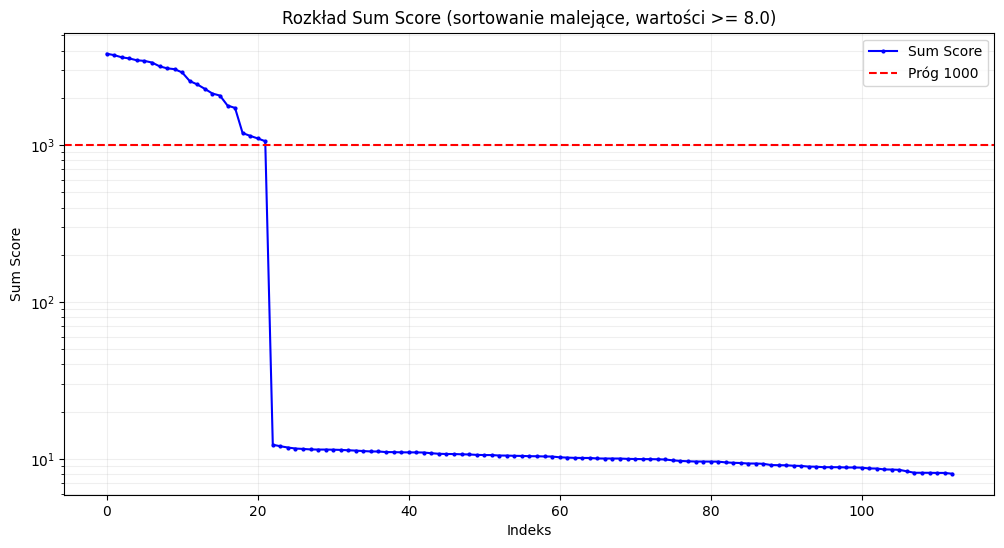


Liczba wartości powyżej 1000: 22
Liczba wartości poniżej 1000: 91


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dane wejściowe
scores = [3049.09375, 1725.4114990234375, 2068.4912109375, 2436.230712890625, 2903.30810546875,
    1058.6982421875, 3179.99462890625, 1103.1944580078125, 3359.77783203125, 1145.250244140625,
    3472.343994140625, 1193.8448486328125, 1788.0166015625, 2132.706787109375, 2559.71533203125,
    3085.02783203125, 3442.43017578125, 3626.2646484375, 3744.73681640625, 3824.470703125,
    2282.439453125, 3568.0712890625, 11.141064643859863, 11.460029602050781, 10.045953750610352,
    11.811152458190918, 11.460722923278809, 8.153353691101074, 8.92629337310791, 11.34330940246582,
    10.862120628356934, 8.510749816894531, 11.636819839477539, 10.570281028747559, 8.328152656555176,
    10.691726684570312, 8.153353691101074, 10.77414608001709, 10.185888290405273, 11.004549026489258,
    10.602749824523926, 10.491874694824219, 9.982231140136719, 12.035172462463379, 9.605793952941895,
    10.146194458007812, 11.147769927978516, 9.90770435333252, 11.212024688720703, 11.43956470489502,
    8.845389366149902, 9.700886726379395, 11.568784713745117, 9.011411666870117, 10.132083892822266,
    9.099650382995605, 10.3982572555542, 9.783438682556152, 9.43963623046875, 11.047178268432617,
    10.058258056640625, 8.677347183227539, 9.132408142089844, 9.60140323638916, 9.612761497497559,
    11.404875755310059, 8.788570404052734, 10.392070770263672, 9.491578102111816, 9.960103034973145,
    8.81076717376709, 10.132431030273438, 10.57339859008789, 10.502090454101562, 8.847617149353027,
    10.047609329223633, 8.039965629577637, 10.994904518127441, 9.651114463806152, 9.406026840209961,
    11.038763046264648, 9.615798950195312, 11.000412940979004, 8.563270568847656,
    10.73965835571289, 10.348819732666016, 9.111100196838379, 11.287073135375977, 8.135591506958008,
    10.356095314025879, 10.046810150146484, 9.996301651000977, 8.135591506958008, 8.688673973083496,
    10.668099403381348, 8.544127464294434, 8.148636817932129, 9.297714233398438, 8.91039752960205,
    8.81302547454834, 9.040570259094238, 9.93913745880127, 11.485160827636719, 10.73364543914795,
    10.440495491027832, 12.303389549255371, 10.22964096069336, 10.45693302154541, 9.960103034973145,
    8.847617149353027, 10.975772857666016, 9.33763313293457, 9.33763313293457]

# Filtrowanie punktów >= 8 i sortowanie malejąco
filtered_scores = sorted([x for x in scores if x >= 8], reverse=True)

# Obliczanie statystyk
stats = {
    'Liczba próbek': len(filtered_scores),
    'Minimum': min(filtered_scores),
    'Maksimum': max(filtered_scores),
    'Średnia': np.mean(filtered_scores),
    'Mediana': np.median(filtered_scores),
    'Odchylenie standardowe': np.std(filtered_scores)
}

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(range(len(filtered_scores)), filtered_scores, 'b.-', markersize=4, label='Sum Score')
plt.axhline(y=1000, color='r', linestyle='--', label='Próg 1000')

# Ustawienia wykresu
plt.yscale('log')  # Skala logarytmiczna na osi Y
plt.xlabel('Indeks')
plt.ylabel('Sum Score')
plt.title('Rozkład Sum Score (sortowanie malejące, wartości >= 8.0)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Wyświetlanie statystyk
for stat, value in stats.items():
    print(f"{stat}: {value:.2f}")

# Wyświetlenie wykresu
plt.show()

# Dodatkowe informacje o liczbie wartości powyżej i poniżej progu 1000
above_threshold = len([x for x in filtered_scores if x > 1000])
print(f"\nLiczba wartości powyżej 1000: {above_threshold}")
print(f"Liczba wartości poniżej 1000: {len(filtered_scores) - above_threshold}")

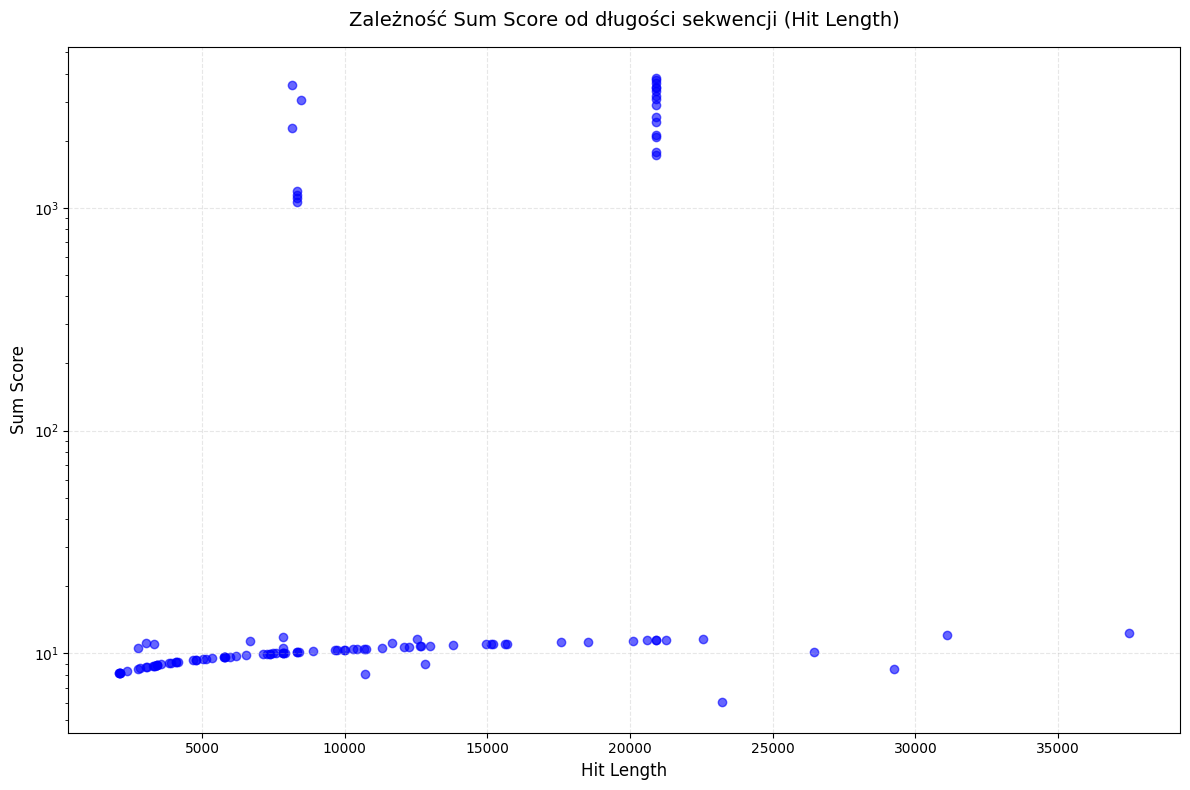


Statystyki:
Liczba punktów danych: 114

Dla Hit Length:
Min: 2081
Max: 37508
Średnia: 11017.30
Mediana: 8321.00

Dla Sum Score:
Min: 6.07
Max: 3824.47
Średnia: 505.83
Mediana: 10.40


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dane
hit_length = [8453, 20902, 20902, 20902, 20902, 8321, 20902, 8321, 20902, 8321, 20902, 8321, 20910, 20910, 20910, 20910, 20910, 20910, 20910, 20910, 8139, 8139, 11665, 20902, 7835, 7847, 20910, 2107, 12811, 6659, 13807, 29247, 12536, 2762, 2379, 12264, 2107, 12986, 26455, 3296, 7847, 10676, 7498, 31121, 5775, 8401, 3032, 7120, 17588, 20600, 3407, 6169, 22541, 3823, 8321, 4065, 10008, 6533, 5146, 15691, 7903, 3032, 4158, 5757, 5803, 20116, 3275, 9964, 5335, 7385, 3326, 8320, 11297, 10751, 3412, 7847, 10699, 15128, 5960, 5027, 15598, 23205, 5815, 15195, 2801, 12678, 9666, 4097, 18527, 2081, 9720, 7840, 7573, 2081, 3056, 12068, 2764, 2100, 4664, 3564, 3331, 3901, 7278, 21248, 12628, 10302, 37508, 8900, 10419, 7385, 3412, 14938, 4794, 4794]

sum_score = [3049.09375, 1725.4114990234375, 2068.4912109375, 2436.230712890625, 2903.30810546875, 1058.6982421875, 3179.99462890625, 1103.1944580078125, 3359.77783203125, 1145.250244140625, 3472.343994140625, 1193.8448486328125, 1788.0166015625, 2132.706787109375, 2559.71533203125, 3085.02783203125, 3442.43017578125, 3626.2646484375, 3744.73681640625, 3824.470703125, 2282.439453125, 3568.0712890625, 11.141064643859863, 11.460029602050781, 10.045953750610352, 11.811152458190918, 11.460722923278809, 8.153353691101074, 8.92629337310791, 11.34330940246582, 10.862120628356934, 8.510749816894531, 11.636819839477539, 10.570281028747559, 8.328152656555176, 10.691726684570312, 8.153353691101074, 10.77414608001709, 10.185888290405273, 11.004549026489258, 10.602749824523926, 10.491874694824219, 9.982231140136719, 12.035172462463379, 9.605793952941895, 10.146194458007812, 11.147769927978516, 9.90770435333252, 11.212024688720703, 11.43956470489502, 8.845389366149902, 9.700886726379395, 11.568784713745117, 9.011411666870117, 10.132083892822266, 9.099650382995605, 10.3982572555542, 9.783438682556152, 9.43963623046875, 11.047178268432617, 10.058258056640625, 8.677347183227539, 9.132408142089844, 9.60140323638916, 9.612761497497559, 11.404875755310059, 8.788570404052734, 10.392070770263672, 9.491578102111816, 9.960103034973145, 8.81076717376709, 10.132431030273438, 10.57339859008789, 10.502090454101562, 8.847617149353027, 10.047609329223633, 8.039965629577637, 10.994904518127441, 9.651114463806152, 9.406026840209961, 11.038763046264648, 6.074395656585693, 9.615798950195312, 11.000412940979004, 8.563270568847656, 10.73965835571289, 10.348819732666016, 9.111100196838379, 11.287073135375977, 8.135591506958008, 10.356095314025879, 10.046810150146484, 9.996301651000977, 8.135591506958008, 8.688673973083496, 10.668099403381348, 8.544127464294434, 8.148636817932129, 9.297714233398438, 8.91039752960205, 8.81302547454834, 9.040570259094238, 9.93913745880127, 11.485160827636719, 10.73364543914795, 10.440495491027832, 12.303389549255371, 10.22964096069336, 10.45693302154541, 9.960103034973145, 8.847617149353027, 10.975772857666016, 9.33763313293457, 9.33763313293457]

# Tworzę wykres
plt.figure(figsize=(12, 8))

# Wykres punktowy
plt.scatter(hit_length, sum_score, alpha=0.6, color='blue')

# Dodaję linie siatki
plt.grid(True, linestyle='--', alpha=0.3)

# Etykiety osi i tytuł
plt.xlabel('Hit Length', fontsize=12)
plt.ylabel('Sum Score', fontsize=12)
plt.title('Zależność Sum Score od długości sekwencji (Hit Length)', fontsize=14, pad=15)

# Skala logarytmiczna dla osi Y ze względu na duży rozrzut wartości
plt.yscale('log')

# Wyświetlam wykres
plt.tight_layout()
plt.show()

# Podstawowe statystyki
print("\nStatystyki:")
print(f"Liczba punktów danych: {len(hit_length)}")
print("\nDla Hit Length:")
print(f"Min: {min(hit_length)}")
print(f"Max: {max(hit_length)}")
print(f"Średnia: {np.mean(hit_length):.2f}")
print(f"Mediana: {np.median(hit_length):.2f}")
print("\nDla Sum Score:")
print(f"Min: {min(sum_score):.2f}")
print(f"Max: {max(sum_score):.2f}")
print(f"Średnia: {np.mean(sum_score):.2f}")
print(f"Mediana: {np.median(sum_score):.2f}")

## Zapis podsumowania statystyk do pliku csv oraz w formacie binarnym pozwalającym na ponowny dostęp do obiektów zawierających dopasowania (Julia Cieszko)

In [ ]:
summary.to_csv("/content/drive/My Drive/stats_dump.csv")
with open("/content/drive/My Drive/stats_dump.pkl", "wb") as f:
    pickle.dump(summary, f)

# Podejście oparte o TNN (Wiktoria Pabiś)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from Bio import SeqIO


def tokenize_sequence(sequence, k=6):
    """
    Dzieli podaną sekwencję DNA na k-mery.

    Args:
        sequence (str): Sekwencja DNA.
        k (int): Długość k-merów. Domyślnie 6.

    Returns:
        List[str]: Lista k-merów.
    """
    return [sequence[i:i + k] for i in range(len(sequence) - k + 1)]

class SequenceDataset(Dataset):
    """
    Klasa Dataset dla sekwencji DNA. Przechowuje sekwencje i ich nagłówki.
    """
    def __init__(self, sequences):
        """
        Inicjalizuje dataset na podstawie listy sekwencji.

        Args:
            sequences (List[dict]): Lista słowników z kluczami "header" i "sequence".
        """
        self.sequences = [seq["sequence"] for seq in sequences]
        self.headers = [seq["header"] for seq in sequences]

    def __len__(self):
        """
        Zwraca liczbę sekwencji w dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Zwraca nagłówek i sekwencję o podanym indeksie.

        Args:
            idx (int): Indeks elementu.

        Returns:
            Tuple[str, str]: Nagłówek i sekwencja DNA.
        """
        return self.headers[idx], self.sequences[idx]

class TransformerNN:
    """
    Klasa dla modelu Transformer opartego na DNA BERT, odpowiedzialnego za generowanie embeddingów sekwencji DNA.
    """
    def __init__(self, model_name="armheb/DNA_bert_6", device=None, k=6):
        """
        Inicjalizuje model, tokenizer oraz ustawia parametry.

        Args:
            model_name (str): Nazwa pretrenowanego modelu.
            device (str, optional): Urządzenie ("cuda" lub "cpu"). Domyślnie wybierane automatycznie.
            k (int): Długość k-merów. Domyślnie 6.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        self.k = k

    def encode_sequence(self, sequence):
        """
        Tokenizuje i generuje embedding dla pełnej sekwencji DNA.

        Args:
            sequence (str): Sekwencja DNA.

        Returns:
            np.ndarray: Średni embedding dla całej sekwencji.
        """
        n_mers = tokenize_sequence(sequence, self.k)
        inputs = self.tokenizer(" ".join(n_mers), return_tensors="pt", padding=True, truncation=True, max_length=512) # max 517 znaków (512 tokenów)
        inputs = {key: val.to(self.device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state
            # print(len(embeddings.mean(dim=1).squeeze(0).cpu().numpy()))
        return embeddings.mean(dim=1).squeeze(0).cpu().numpy()


def search_transformer_nn(query_sequence, sequences, k=6, threshold=0.9):
    """
    Wyszukiwanie sekwencji zapytania w bazie danych na podstawie embeddingów.

    Args:
        query_sequence (str): Sekwencja DNA zapytania.
        sequences (List[dict]): Lista sekwencji DNA z nagłówkami.
        k (int): Długość k-merów. Domyślnie 6.
        threshold (float): Minimalna wartość podobieństwa, aby dopasowanie było uznane. Domyślnie 0.9.

    Returns:
        List[Tuple[str, int, str, float]]: Lista dopasowań w formacie
        (nagłówek, indeks startowy, dopasowana sekwencja, podobieństwo).
    """
    dataset = SequenceDataset(sequences)
    dataloader = DataLoader(dataset, batch_size=1)
    transformer = TransformerNN(k=k)

    query_embedding = transformer.encode_sequence(query_sequence)
    results = []

    for header, sequence in dataloader:
        header = header[0]
        sequence = sequence[0]
        for i in range(len(sequence) - len(query_sequence) + 1):
            window = sequence[i:i + len(query_sequence)]

            window_embedding = transformer.encode_sequence(window)

            # Prawdopodobieństwo kosinusowe (podobieństwa)
            similarity = cosine_similarity(
                query_embedding.reshape(1, -1),
                window_embedding.reshape(1, -1)
            )[0, 0]

            if similarity > threshold:
                results.append((header, i, window, similarity))
    return results

# Przykladowa baza danych
sequences = [
    {"header": "seq1", "sequence": "TGTGTGTTGTGAGACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAATAAGGAGAACAAAGACCATTCCTTAGAAAGGGGAAGAGCAAGTCTCATTTTTTCCTTAAAGAATGA"},
    {"header": "seq2", "sequence": "GACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAAAA"}

]

# Przykładowa sekwencja zapytania
query_sequence = "GACCCAGCCTGCACCTACTGGCGCCCGAGTT"

hits = search_transformer_nn(query_sequence=query_sequence, sequences=sequences, k=6, threshold=0.999)

if hits:
    for header, index, matched_sequence, score in hits:
        print(f"Match found in sequence {header} at index {index}: {matched_sequence} (score: {score:.2f})")
else:
    print("No matches found.")

# Część kodu działająca na sekwencji zapytania TPH1 i szukanie jej w rzeczywistej bazie danych.

# def load_fasta_database(file_path):
#     """
#     Wczytuje sekwencje z pliku FASTA.

#     :param file_path: Ścieżka do pliku FASTA.
#     :return: Lista słowników z nagłówkiem i sekwencją.
#     """
#     sequences = []
#     with open(file_path, "r") as fasta_file:
#         for record in SeqIO.parse(fasta_file, "fasta"):
#             sequences.append({"header": record.id, "sequence": str(record.seq)})
#     return sequences


# protein_sequence = fetch_entrez_sequence("NM_004179", "258902@student.pwr.edu.pl", db="nucleotide")
# print(f"TPH1 protein sequence:\n{protein_sequence}")

# database_path = "/content/drive/My Drive/hgg/hgg_mags_1/SRR2726600_bin.49.fa"
# # SRR585697_bin.21

# sequences = load_fasta_database(database_path)

# hits = search_transformer_nn(
#     query_sequence=str(protein_sequence),
#     sequences=sequences,
#     k=6,
#     threshold=0.95
# )

# if hits:
#     for header, index, matched_sequence, score in hits:
#         print(f"Match found in sequence {header} at index {index}: {matched_sequence} (score: {score:.2f})")
# else:
#     print("No matches found.")


/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
T

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/359M [00:00<?, ?B/s]

Match found in sequence seq1 at index 12: GACCCAGCCTGCACCTACTGGCGCCCGAGTT (score: 1.00)
Match found in sequence seq2 at index 0: GACCCAGCCTGCACCTACTGGCGCCCGAGTT (score: 1.00)


## Analiza uzyskanego modelu (Natalia Kowal)

Analizowanie embeddingów...


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Analizowanie wydajności...


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Analizowanie tokenizacji...


100%|██████████| 2/2 [00:00<00:00, 336.96it/s]


Generowanie wizualizacji...


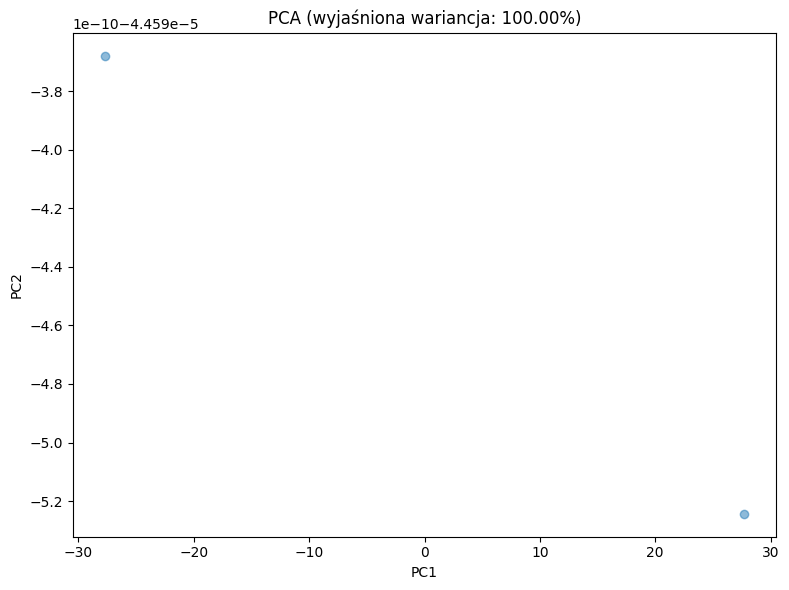

{'embedding_stats': {'wymiar_embeddingu': 768,
  'średnia': 0.0012641369,
  'odchylenie_std': 0.37978724,
  'min': -1.0652711,
  'max': 1.0186238,
  'średnia_norma_l2': 10.51947,
  'rzadkość': 0.0},
 'performance_metrics': {'czas_kodowania_na_sekwencję': 0.21201825141906738,
  'zużycie_pamięci_MB': 2794.421875,
  'czas_wyszukiwania': 1.3353476524353027,
  'średnie_podobieństwo': 0.76915276,
  'odchylenie_podobieństwa': 0.050952762},
 'tokenization_stats': {'średnia_liczba_tokenów': 106.0,
  'max_tokenów': 144,
  'min_tokenów': 68,
  'odchylenie_tokenów': 38.0,
  'długość_k-meru': 6}}

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from tqdm import tqdm
import time
import psutil
import torch

class TransformerNNAnalyzer:
    def __init__(self, transformer, query_sequence, sequences):
        """
        Args:
            transformer: Instancja TransformerNN
            query_sequence: Sekwencja zapytania
            sequences: Lista słowników z kluczami "header" i "sequence"
        """
        self.transformer = transformer
        self.query_sequence = query_sequence
        self.dataset = SequenceDataset(sequences)
        self.dataloader = DataLoader(self.dataset, batch_size=1)

    def analyze_embeddings(self) -> Dict:
        """Analiza właściwości embeddingów"""
        print("Analizowanie embeddingów...")
        embeddings = []

        for _, sequence in tqdm(self.dataloader):
            emb = self.transformer.encode_sequence(sequence[0])
            embeddings.append(emb)

        embeddings = np.vstack(embeddings)

        stats = {
            "wymiar_embeddingu": embeddings.shape[1],
            "średnia": np.mean(embeddings),
            "odchylenie_std": np.std(embeddings),
            "min": np.min(embeddings),
            "max": np.max(embeddings),
            "średnia_norma_l2": np.mean(np.linalg.norm(embeddings, axis=1)),
            "rzadkość": np.mean(embeddings == 0)
        }
        return stats, embeddings

    def analyze_performance(self) -> Dict:
        """Analiza wydajności modelu"""
        print("Analizowanie wydajności...")

        # Pomiar czasu kodowania
        start_time = time.time()
        query_emb = self.transformer.encode_sequence(self.query_sequence)
        encoding_time = time.time() - start_time

        # Pomiar zużycia pamięci
        memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

        # Pomiar wydajności wyszukiwania
        start_time = time.time()
        database_emb = []
        for _, sequence in tqdm(self.dataloader):
            emb = self.transformer.encode_sequence(sequence[0])
            database_emb.append(emb)
        database_emb = np.vstack(database_emb)

        similarities = cosine_similarity(
            query_emb.reshape(1, -1),
            database_emb
        )[0]
        search_time = time.time() - start_time

        metrics = {
            "czas_kodowania_na_sekwencję": encoding_time,
            "zużycie_pamięci_MB": memory_usage,
            "czas_wyszukiwania": search_time,
            "średnie_podobieństwo": np.mean(similarities),
            "odchylenie_podobieństwa": np.std(similarities)
        }
        return metrics

    def analyze_tokenization(self) -> Dict:
        """Analiza tokenizacji"""
        print("Analizowanie tokenizacji...")
        token_lengths = []

        for _, sequence in tqdm(self.dataloader):
            n_mers = tokenize_sequence(sequence[0], self.transformer.k)
            tokens = self.transformer.tokenizer(" ".join(n_mers), return_tensors="pt")
            token_lengths.append(len(tokens['input_ids'][0]))

        stats = {
            "średnia_liczba_tokenów": np.mean(token_lengths),
            "max_tokenów": np.max(token_lengths),
            "min_tokenów": np.min(token_lengths),
            "odchylenie_tokenów": np.std(token_lengths),
            "długość_k-meru": self.transformer.k
        }
        return stats

    def visualize_embeddings(self, embeddings: np.ndarray) -> None:
        """Wizualizacja embeddingów"""
        print("Generowanie wizualizacji...")

        if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
            print("Ostrzeżenie: Dane zawierają wartości NaN lub inf")
            embeddings = np.nan_to_num(embeddings)

        scaler = StandardScaler()
        embeddings_normalized = scaler.fit_transform(embeddings)

        # PCA
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings_normalized)
        explained_variance = np.sum(pca.explained_variance_ratio_)

        plt.figure(figsize=(8, 6))

        # Tylko wykres PCA jeśli mamy za mało próbek dla t-SNE
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
        plt.title(f'PCA (wyjaśniona wariancja: {explained_variance:.2%})')
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        # t-SNE tylko jeśli mamy wystarczającą liczbę próbek
        if embeddings.shape[0] > 5:  # Minimum 5 próbek dla t-SNE
            plt.figure(figsize=(8, 6))
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, embeddings.shape[0]-1))
            embeddings_tsne = tsne.fit_transform(embeddings_normalized)
            plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
            plt.title('t-SNE')
            plt.xlabel('Składowa 1')
            plt.ylabel('Składowa 2')

        plt.tight_layout()
        plt.show()


    def run_full_analysis(self) -> Dict:
        """Przeprowadzenie pełnej analizy"""
        results = {}

        # Analiza embeddingów
        embedding_stats, embeddings = self.analyze_embeddings()
        results['embedding_stats'] = embedding_stats

        # Analiza wydajności
        performance_metrics = self.analyze_performance()
        results['performance_metrics'] = performance_metrics

        # Analiza tokenizacji
        tokenization_stats = self.analyze_tokenization()
        results['tokenization_stats'] = tokenization_stats

        # Wizualizacje
        self.visualize_embeddings(embeddings)

        return results


def analyze_transformer(query_sequence, sequences, k=6):
    transformer = TransformerNN(k=k)
    analyzer = TransformerNNAnalyzer(transformer, query_sequence, sequences)
    results = analyzer.run_full_analysis()
    return results


# Dane do analizy modelu
sequences = [
    {"header": "seq1", "sequence": "TGTGTGTTGTGAGACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAATAAGGAGAACAAAGACCATTCCTTAGAAAGGGGAAGAGCAAGTCTCATTTTTTCCTTAAAGAATGA"},
    {"header": "seq2", "sequence": "GACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAAAA"}

]
query_sequence = "GACCCAGCCTGCACCTACTGGCGCCCGAGTT"
analyze_transformer(query_sequence, sequences)


### Funkcje testujące TNN (Wiktoria Pabiś)

In [ ]:
def test_exact_match():
    """
    Testuje wyszukiwanie dokładnego dopasowania sekwencji zapytania w bazie danych.
    """
    sequences = [
        {"header": "seq1", "sequence": "TGTGTGTTGTGAGACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAATAAGGAGAACAAAGACCATTCCTTAGAAAGGGGAAGAGCAAGTCTCATTTTTTCCTTAAAGAATGA"},
        {"header": "seq2", "sequence": "GACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGAC"}
    ]
    query_sequence = "GACCCAGCCTGCACCTACTGGCGCCCGAGTT"
    hits = search_transformer_nn(query_sequence=query_sequence, sequences=sequences, k=6, threshold=0.99)

    assert len(hits) == 2, f"Expected 2 matches, found {len(hits)}."

    assert hits[0][0] == "seq1", "Expected first match in 'seq1'."
    assert hits[0][1] == 12, f"Expected first match starting at index 12, found {hits[0][1]}."

    assert hits[1][0] == "seq2", "Expected second match in 'seq2'."
    assert hits[1][1] == 0, f"Expected second match starting at index 0, found {hits[1][1]}."

    print("test_exact_match passed!")


def test_no_match_high_threshold():
    """
    Testuje przypadek, gdy nie ma dospasowań.
    """
    sequences = [
        {"header": "seq1", "sequence": "TGTGTGTTGTGAGACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGACAATAAGGAGAACAAAGACCATTCCTTAGAAAGGGGAAGAGCAAGTCTCATTTTTTCCTTAAAGAATGA"},
        {"header": "seq2", "sequence": "GACCCAGCCTGCACCTACTGGCGCCCGAGTTTTAGAGAATTACTCCAAATTCATCATGATTGAAGAC"}
    ]
    query_sequence = "AACCCAGCCTGCACCTACTGGCGCCCGAGTC"
    hits = search_transformer_nn(query_sequence=query_sequence, sequences=sequences, k=6, threshold=0.999)

    assert len(hits) == 0, f"Expected no matches, found {len(hits)}."
    print("test_no_match_high_threshold passed!")


test_exact_match()
test_no_match_high_threshold()


test_exact_match passed!
test_no_match_high_threshold passed!
